In [ ]:
! pip install cripser
! pip install persim

In [ ]:
! pip install scikit-image

In [4]:
## load necessary libraries
%matplotlib inline
#%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider, Button, RadioButtons
import os,time,subprocess,glob
from PIL import Image
import cripser as cr
import tcripser as tcr
import persim
import skimage
from skimage import io
from skimage.transform import rotate
from skimage.data import cells3d
from skimage.filters import threshold_otsu
from scipy.ndimage import distance_transform_edt,convolve
import os, re
from tkinter import filedialog
import tkinter as tk



In [ ]:
def resize_images(input_folder, output_folder, target_size):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through each file in the input folder
    for filename in os.listdir(input_folder):
        # Check if the file is an image file
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            # Open the image
            img_path = os.path.join(input_folder, filename)
            img = Image.open(img_path)

            # Resize the image
            resized_img = img.resize(target_size)


            # Save the resized image to the output folder
            output_path = os.path.join(output_folder, filename)
            resized_img.save(output_path)

    print("All images have been resized and saved to the output folder.")

def select_folder():
    root = tk.Tk()
    root.withdraw() # Hide the root window
    folder_path = filedialog.askdirectory()
    return folder_path

# Interactively select the input folder
input_folder = select_folder()

# Create the output folder with '_resized' extension
output_folder = input_folder + "_resized"

# Set the target size for resizing
target_size = (300, 300)  # Change this to the desired dimensions

# Resize images in the input folder and save to the output folder
resize_images(input_folder, output_folder, target_size)

In [5]:
import matplotlib
matplotlib.rcParams['text.usetex'] = False

In [6]:
root = tk.Tk()
root.withdraw()  # Hide the root window

# Ask the user to select the folder containing the images
img_folder = filedialog.askdirectory(title="Select the folder containing images")

if img_folder:  # If a folder is selected
    # Change directory to the selected folder
    os.chdir(img_folder)

    volfile = "img.npy"  ## the 3d image will be saved into this 3D numpy array file

    # Create a 3d stack from 2d images
    if os.path.isdir(img_folder):
        # Load image files from a dir and stack into a 3D array of type float64
        input_files = os.path.join(img_folder, "*.png")
        files = [f for f in glob.glob(input_files)]
        files.sort(key=lambda val: int(re.sub("\\D", "", val + "0")))
        img3d = np.dstack([Image.open(f).convert('L') for f in files]).astype('f8')
    else:
        ## Create a dummy stack from a single 2d image
        img3d = np.dstack([rotate(img2d, 10 * i) for i in range(8)])
        # img3d = skimage.util.img_as_float(cells3d()[:, 1, :, :]).transpose((1,2,0))  # requires pooch

    np.save(volfile, img3d.astype(np.float64))

    # Rescaling
    #img3d = skimage.transform.resize(img3d,(130,160,6))

    #plt.imshow(img3d[:, :, img3d.shape[-1] // 2])
    #plt.colorbar()  # Add colorbar for better interpretation if needed
    #plt.show()
    #print(img3d.shape, img3d.dtype, f"{np.min(img3d)}--{np.max(img3d)}")
else:
    print("No folder selected. Exiting.")

Betti numbers:  [13847, 19954, 4636]
Betti numbers:  [6374, 19501, 10570]
elapsed_time:8.117719888687134 sec


c:\Users\sonii\AppData\Local\Programs\Python\Python312\Lib\site-packages\persim\visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]
c:\Users\sonii\AppData\Local\Programs\Python\Python312\Lib\site-packages\persim\visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]


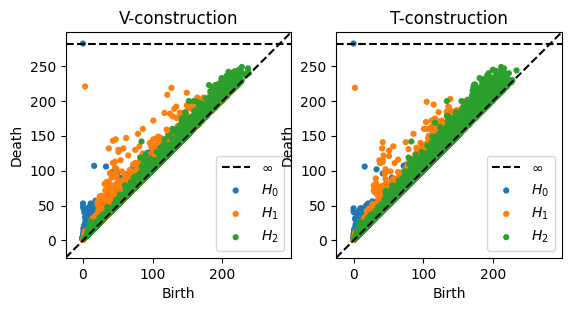

In [7]:
start = time.time()
pd = cr.computePH(img3d)
pds = [pd[pd[:,0] == i] for i in range(3)]
print("Betti numbers: ",[len(pds[i]) for i in range(len(pds))])

# compute PH for the T-construction of the original image (pixel value filtration)
pdt = tcr.computePH(img3d)
pdst = [pdt[pdt[:,0] == i] for i in range(3)]
print("Betti numbers: ",[len(pdst[i]) for i in range(len(pdst))])

print ("elapsed_time:{} sec".format(time.time() - start))
## plot persistent diagram using persim
fig,axs = plt.subplots(1,2)
persim.plot_diagrams([p[:,1:3] for p in pds], ax=axs[0], title='V-construction')
persim.plot_diagrams([p[:,1:3] for p in pdst], ax=axs[1], title='T-construction')


In [17]:
import numpy as np
import time
import persim
import matplotlib.pyplot as plt
from scipy.stats import entropy

def persistent_entropy(dgm):
    # Compute counts of lifetimes in the diagram
    counts = np.bincount(np.clip(np.ceil(dgm[:, 1] - dgm[:, 0]).astype(int), 0, None))
    
    # Calculate entropy
    return entropy(counts[counts != 0])

# Your code to compute persistent diagrams
start = time.time()
pd = cr.computePH(img3d)
pds = [pd[pd[:,0] == i] for i in range(3)]
print("Betti numbers for V-construction: ",[len(pds[i]) for i in range(len(pds))])

pdt = tcr.computePH(img3d)
pdst = [pdt[pdt[:,0] == i] for i in range(3)]
print("Betti numbers for T-construction: ",[len(pdst[i]) for i in range(len(pdst))])
print("Elapsed time: {} sec".format(time.time() - start))

# Compute persistent entropy for each dimension
e0_v = persistent_entropy(pds[0])
e1_v = persistent_entropy(pds[1])
e2_v = persistent_entropy(pds[2])

e0_t = persistent_entropy(pdst[0])
e1_t = persistent_entropy(pdst[1])
e2_t = persistent_entropy(pdst[2])

# Display the results
print("Persistent entropy for H0 (V-construction):", e0_v)
print("Persistent entropy for H1 (V-construction):", e1_v)
print("Persistent entropy for H2 (V-construction):", e2_v)

print("Persistent entropy for H0 (T-construction):", e0_t)
print("Persistent entropy for H1 (T-construction):", e1_t)
print("Persistent entropy for H2 (T-construction):", e2_t)


Betti numbers for V-construction:  [13847, 19954, 4636]
Betti numbers for T-construction:  [6374, 19501, 10570]
Elapsed time: 8.170225858688354 sec
Persistent entropy for H0 (V-construction): 4.003299846954214
Persistent entropy for H1 (V-construction): 4.297997214025762
Persistent entropy for H2 (V-construction): 4.18916564669247
Persistent entropy for H0 (T-construction): 3.7602221784389402
Persistent entropy for H1 (T-construction): 4.295249214877398
Persistent entropy for H2 (T-construction): 4.338969479352494
